# numerical prediction



In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense


In [34]:
# Feature sets
lin_feats = ['activity', 'appCat.communication', 'appCat.utilities',
             'call', 'circumplex.valence', 'mood', 'sms',
             'screen_log', 'activity_log', 'call_sms_ratio']
rnn_feats = ['appCat.communication', 'screen', 'appCat.builtin',
             'appCat.finance', 'appCat.unknown', 'mood']


In [35]:
# Load data
df = pd.read_pickle('df_feat.pkl')
if 'mood_cat' in df.columns:
    df = df.drop(columns=['mood_cat'])
X_lin = df[lin_feats]
X_rnn = df[rnn_feats]
y = df['nextday']


In [36]:
# Train/test split
X_train_lin, X_test_lin, y_train, y_test = train_test_split(
    X_lin, y, test_size=1/3, random_state=42
)
X_train_rnn, X_test_rnn, _, _ = train_test_split(
    X_rnn, y, test_size=1/3, random_state=42
)


In [37]:
# pipeline

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    ridge_pipe, param_grid, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid.fit(X_train_lin, y_train)
best_alpha = grid.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_alpha}")


Best Ridge alpha: 0.1


In [38]:
# Evaluate Ridge
pred_lin = grid.predict(X_test_lin)
print("Ridge Test MSE:", mean_squared_error(y_test, pred_lin))
print("Ridge Test MAE:", mean_absolute_error(y_test, pred_lin))
print("Ridge Test R2 :", r2_score(y_test, pred_lin))


Ridge Test MSE: 0.511510977803592
Ridge Test MAE: 0.5272909990001434
Ridge Test R2 : 0.30608779844546286


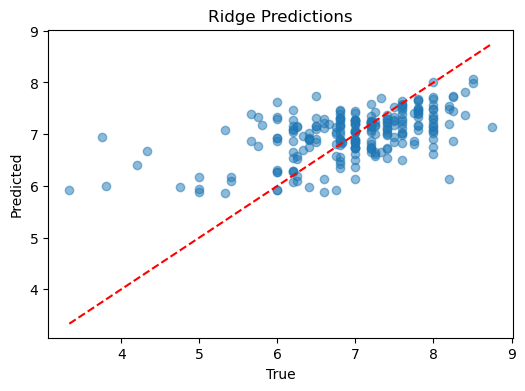

In [39]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, pred_lin, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Ridge Predictions')
plt.show()


# RNN

In [40]:
X_tr = X_train_rnn.values.reshape(len(X_train_rnn), 1, len(rnn_feats))
X_te = X_test_rnn.values.reshape(len(X_test_rnn), 1, len(rnn_feats))

# build final RNN
model = Sequential()
model.add(SimpleRNN(500, input_shape=(1, len(rnn_feats)), activation='tanh'))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# train
model.fit(X_tr, y_train, epochs=20, batch_size=32, verbose=1)

# predict
pred_rnn = model.predict(X_te).ravel()
print("RNN Test MSE:", mean_squared_error(y_test, pred_rnn))
print("RNN Test MAE:", mean_absolute_error(y_test, pred_rnn))
print("RNN Test R2 :", r2_score(y_test, pred_rnn))


Epoch 1/20
16/16 [==============================] - 2s 4ms/step - loss: 18.0744
Epoch 2/20
16/16 [==============================] - 0s 4ms/step - loss: 3.0109
Epoch 3/20
16/16 [==============================] - 0s 4ms/step - loss: 1.0208
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.7817
Epoch 5/20
16/16 [==============================] - 0s 4ms/step - loss: 0.7013
Epoch 6/20
16/16 [==============================] - 0s 4ms/step - loss: 0.6886
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6585
Epoch 8/20
16/16 [==============================] - 0s 4ms/step - loss: 0.6328
Epoch 9/20
16/16 [==============================] - 0s 5ms/step - loss: 0.5957
Epoch 10/20
16/16 [==============================] - 0s 5ms/step - loss: 0.5941
Epoch 11/20
16/16 [==============================] - 0s 4ms/step - loss: 0.5820
Epoch 12/20
16/16 [==============================] - 0s 4ms/step - loss: 0.5530
Epoch 13/20
16/16 [=============================

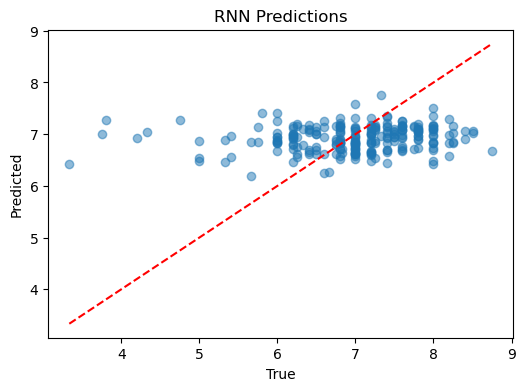

In [41]:
# Plot true vs predicted for RNN
plt.figure(figsize=(6,4))
plt.scatter(y_test, pred_rnn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('RNN Predictions')
plt.show()

8/8 [==============================] - 0s 2ms/step


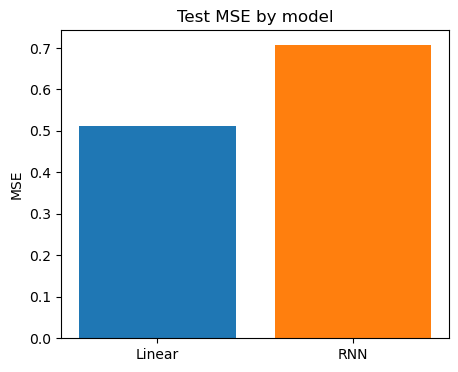

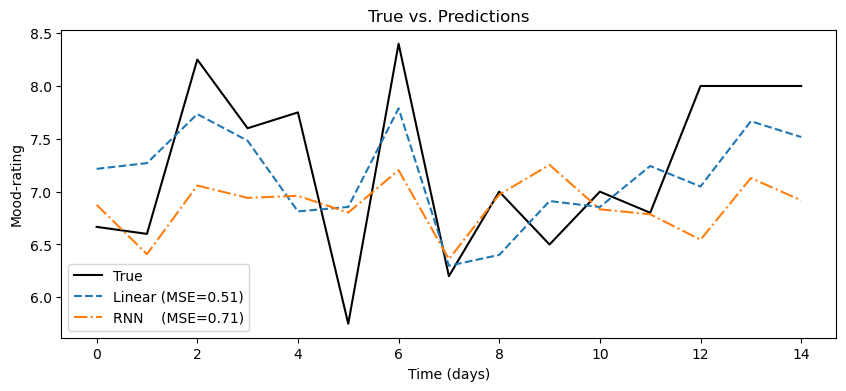

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

# Define the RNN model architecture
def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(500, input_shape=input_shape, activation='tanh'))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model with the correct input shape (timesteps=1, features=X_train_rnn.shape[1])
input_shape = (1, X_train_rnn.shape[1])
rnn_model = build_rnn(input_shape)

X_train_seq = X_train_rnn.values.reshape(-1, 1, X_train_rnn.shape[1])
rnn_model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# 1) Build and fit the Ridge pipeline (linear model)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
ridge_pipe.fit(X_train_lin, y_train)

# 2) Build and fit the RNN model
X_train_seq = X_train_rnn.values.reshape(-1, 1, X_train_rnn.shape[1])
rnn_model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)

# 3) Predict
y_pred_lin = ridge_pipe.predict(X_test_lin)
X_test_seq = X_test_rnn.values.reshape(-1, 1, X_test_rnn.shape[1])
y_pred_rnn = rnn_model.predict(X_test_seq).flatten()

# 4) Compute MSE
from sklearn.metrics import mean_squared_error
mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)

# 5a) Bar chart of MSE
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.bar(['Linear','RNN'], [mse_lin, mse_rnn], color=['C0','C1'])
plt.ylabel('MSE')
plt.title('Test MSE by model')
plt.show()

# 5b) Overlay true vs. predicted
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:15],   'k-',   label='True')
plt.plot(y_pred_lin[:15],      'C0--', label=f'Linear (MSE={mse_lin:.2f})')
plt.plot(y_pred_rnn[:15],      'C1-.', label=f'RNN    (MSE={mse_rnn:.2f})')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Mood-rating')
plt.title('True vs. Predictions')
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions (assuming you have these from previous cells)
# y_pred_lin = ridge_pipe.predict(X_test_lin)
# y_pred_rnn = rnn_model.predict(X_test_seq).flatten()

# MSE
mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)

# MAE
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)

print(f"Linear Model - MSE: {mse_lin:.3f}, MAE: {mae_lin:.3f}")
print(f"RNN Model    - MSE: {mse_rnn:.3f}, MAE: {mae_rnn:.3f}")

Linear Model - MSE: 0.512, MAE: 0.526
RNN Model    - MSE: 0.707, MAE: 0.639
